In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# Saving model
import joblib


In [3]:
data_path = '/content/drive/MyDrive/data.csv'
df = pd.read_csv(data_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Shape: (12000, 14)
Columns: ['Age', 'Gender', 'Education', 'Income', 'Debt', 'Credit_Score', 'Loan_Amount', 'Loan_Term', 'Num_Credit_Cards', 'Payment_History', 'Employment_Status', 'Residence_Type', 'Marital_Status', 'Creditworthiness']
   Age  Gender    Education  Income   Debt  Credit_Score  Loan_Amount  \
0   56  Female       Master  149406  34089           581        49200   
1   69  Female  High School   78896   8626           648        20147   
2   46  Female       Master  119339  46281           329        41307   
3   32    Male  High School  131067  29403           816        19019   
4   60    Male          PhD   38001  30032           673        16317   

   Loan_Term  Num_Credit_Cards Payment_History Employment_Status  \
0         60                 4             Bad        Unemployed   
1         24                 7            Good          Employed   
2         12                 8             Bad        Unemployed   
3         60                 8             Bad      

In [4]:
# Create new features to improve model performance
df['debt_to_income'] = df['Debt'] / (df['Income'] + 1e-9)
df['loan_to_income'] = df['Loan_Amount'] / (df['Income'] + 1e-9)


In [5]:
from sklearn.model_selection import train_test_split

TARGET = 'Creditworthiness'
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Define transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into a single preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Build pipeline with preprocessing and model
clf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search for best parameters
gs = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'clf__max_depth': None, 'clf__n_estimators': 200}


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       714
           1       0.70      1.00      0.82      1686

    accuracy                           0.70      2400
   macro avg       0.35      0.50      0.41      2400
weighted avg       0.49      0.70      0.58      2400

ROC AUC Score: 0.4935795195895678


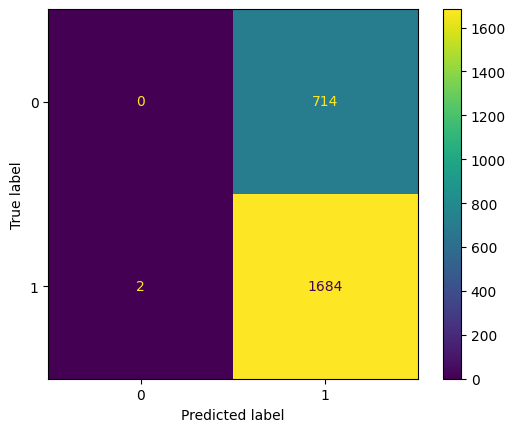

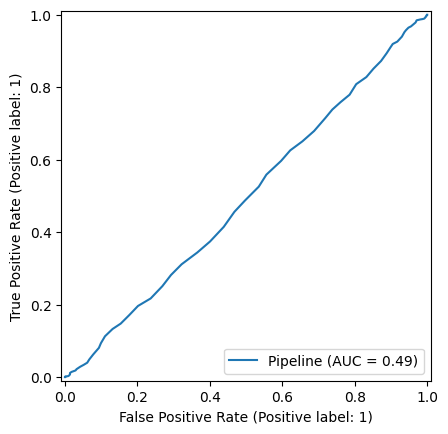

In [8]:
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()
